In [13]:
from PySDM.backends.default import Default
from PySDM.physics.constants import si
from PySDM.physics import constants as const, formulae as fml
from PySDM.dynamics.condensation import condensation
from PySDM.dynamics import Condensation
from PySDM.initialisation.spectra import Lognormal
from PySDM.particles_builder import ParticlesBuilder
from PySDM.environments import MoistLagrangianParcelAdiabatic
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import constant_multiplicity
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.initialisation.moist_environment_init import moist_environment_init
from PySDM.dynamics.condensation import condensation
from PySDM.initialisation.r_wet_init import r_wet_init
from PySDM.initialisation.multiplicities import discretise_n
from PySDM.dynamics.chemical_reaction.products.particle_dry_size_spectrum import ParticlesDrySizeSpectrum
from PySDM.dynamics.chemical_reaction.oxidation.dynamic import ChemicalReaction, COMPOUNDS
from PySDM.dynamics.chemical_reaction.oxidation.constants import dry_air_d


import numpy as np

minute = 60 * si.seconds

class SetupAdiabatic:
    r_min = 1e-2 * si.micrometre
    r_max = 50 * si.micrometre
    
    n_sd = 2 ** 10
    dt = 0.4 * si.s # Four times bigger than in the paper

    dry_air_d = 1150 * si.kilogram / si.metre ** 3
    mass_of_dry_air = 100 * si.kilogram
    T0 = 285.2 * si.K
    p0 = 950 * si.hectopascals
    RH0 = 0.95
    q0 = const.eps / (p0 / RH0 / fml.pvs(T0) - 1)
    z0 = 600 * si.metres
    
    up_velocity = 0.5 * si.m / si.s
    
    mean_rad = 0.4 * si.micrometre
    geo_stdev = 2
    tot_aer_conc = 566 / si.cm ** 3 / const.rho_STP
    
    kappa = 0.61
    
    seed = 44
         
    time = 1200 * si.s
    steps = int(time / dt)
    steps_per_sample = 1
    
    backend = Default
    spectrum = Lognormal(norm_factor=tot_aer_conc, m_mode=mean_rad, s_geom=geo_stdev)
    
    rho = 1000 * si.kilogram / si.metre**3

    adaptive = True
    coord = 'volume logarithm'
    rtol_x = condensation.default_rtol_x
    rtol_thd = condensation.default_rtol_thd

    radius_bins_edges = np.logspace(np.log10(r_min / si.micrometre), np.log10(r_max / si.micrometre), num=64, endpoint=True) * si.micrometre

    t0 = 1200 * si.second
    f0 = 1 / 1000 * si.hertz
    
    @staticmethod
    def w(t):
        return 0.5 * (np.where(t < SetupAdiabatic.t0, 1, np.sign(-np.sin(2*np.pi * SetupAdiabatic.f0 * (t-SetupAdiabatic.t0))))) * si.metre / si.second



In [14]:
def getstate(setup, particles):
    return particles.products['Dry Radius Spectrum'].get(fml.volume(setup.radius_bins_edges)) * setup.rho

def get_ppb_so2(sdchem, drop, particles):
    # 3 - SO2
    so2 = sdchem.environment[sdchem.environment_indices['SO2']]
    drop_so2 = np.dot(drop, np.ones_like(particles.state['n'])) / sdchem.dv
    return (so2 * sdchem.ideal_gas_volume,
            (drop_so2) * sdchem.ideal_gas_volume,
            (so2 + drop_so2 ) * sdchem.ideal_gas_volume)

radii = []

def run(setup):
    particles_builder = ParticlesBuilder(n_sd=setup.n_sd, backend=setup.backend)
    dry_radii, n = constant_multiplicity(setup.n_sd, setup.spectrum,
                                                              (setup.r_min, setup.r_max))
    
    n = discretise_n(n)
    
    particles_builder.set_environment(MoistLagrangianParcelAdiabatic, {
        "dt": setup.dt,
        "mass_of_dry_air": setup.mass_of_dry_air,
        "p0": setup.p0,
        "q0": setup.q0,
        "T0": setup.T0,
        "w": setup.w,
        "z0": setup.z0
    })
    
    environment = particles_builder.particles.environment
    dry_v = fml.volume(radius=dry_radii)
    r_wet = r_wet_init(dry_radii, environment, np.zeros_like(n), setup.kappa)
    particles_builder.register_dynamic(Condensation, {
        "kappa": setup.kappa,
        "coord": setup.coord,
        "adaptive": setup.adaptive,
        "rtol_x": setup.rtol_x,
        "rtol_thd": setup.rtol_thd,
    })
    particles_builder.register_dynamic(ChemicalReaction, {"dissolve_steps": 5, "oxidize_steps": 5, "air_d": setup.dry_air_d})
    
    wet_v = fml.volume(radius=r_wet)
    
    attributes = {
        'n': n,
        'dry volume': dry_v,
        'volume': wet_v,
        **ChemicalReaction.get_starting_amounts(dry_v, wet_v)
    }
    products = {ParticlesDrySizeSpectrum: {}}
    
    particles = particles_builder.get_particles(attributes, products)
    
    times = []
    products = []
    concs = []
    radii.append(getstate(setup, particles))
    for i in range(0, setup.steps // setup.steps_per_sample):
        state = particles.state
        
        particles.run(setup.steps_per_sample)
        times.append(i * setup.steps_per_sample * setup.dt)
        
        # HACK
        sdchem = particles.dynamics[str(ChemicalReaction)].sdchem
        
        products.append([
            # LWC
            setup.rho * np.dot(state['n'], state['volume']),
            # SO2
            get_ppb_so2(sdchem, state['SO2'], particles),
            # pH, +3 to account for unit (si: m^3, traditional: L)
            -np.log10(np.mean(state['Hp']/state['volume'])) + 3,
        ])

        concs.append([np.mean(state[x]) for x in COMPOUNDS.keys()])
        
        print(-np.log10(np.mean(state['Hp']/state['volume'])) + 3)
        if i > 0 and i % 400 == 0:
            radii.append(getstate(setup, particles)) 
    
    radii.append(getstate(setup, particles)) 

    return ((times, products), radii, concs)

In [15]:
setup = SetupAdiabatic()
res = run(setup)

Chemistry total took 0.044s, skipped 1024/1024
-0.12060684032466851
Chemistry total took 0.040s, skipped 1024/1024
-0.11986437982081899
Chemistry total took 0.038s, skipped 1024/1024
-0.11905140350002208
Chemistry total took 0.035s, skipped 1024/1024
-0.11821484273949512
Chemistry total took 0.038s, skipped 1024/1024
-0.11736700182195392
Chemistry total took 0.040s, skipped 1024/1024
-0.1165124138067859
Chemistry total took 0.045s, skipped 1024/1024
-0.11565311547785617
Chemistry total took 0.041s, skipped 1024/1024
-0.11479016223955263
Chemistry total took 0.034s, skipped 1024/1024
-0.11392414493641878
Chemistry total took 0.038s, skipped 1024/1024
-0.11305542182644546
Chemistry total took 0.040s, skipped 1024/1024
-0.11218421690140845
Chemistry total took 0.046s, skipped 1024/1024
-0.11131068504432795
Chemistry total took 0.035s, skipped 1024/1024
-0.11043492435612201
Chemistry total took 0.039s, skipped 1024/1024
-0.1095570001746351
Chemistry total took 0.038s, skipped 1024/1024
-0.

0.0008437029675789631
Chemistry total took 0.043s, skipped 1024/1024
0.0019958505981962915
Chemistry total took 0.037s, skipped 1024/1024
0.003151199919944059
Chemistry total took 0.035s, skipped 1024/1024
0.004309772155764335
Chemistry total took 0.034s, skipped 1024/1024
0.005471576838425474
Chemistry total took 0.038s, skipped 1024/1024
0.006636639701414371
Chemistry total took 0.035s, skipped 1024/1024
0.00780497206339037
Chemistry total took 0.036s, skipped 1024/1024
0.008976596623052835
Chemistry total took 0.038s, skipped 1024/1024
0.010151525326693278
Chemistry total took 0.037s, skipped 1024/1024
0.011329782801963617
Chemistry total took 0.039s, skipped 1024/1024
0.012511384241060242
Chemistry total took 0.040s, skipped 1024/1024
0.013696348834216998
Chemistry total took 0.036s, skipped 1024/1024
0.01488469234006562
Chemistry total took 0.035s, skipped 1024/1024
0.01607643624685906
Chemistry total took 0.035s, skipped 1024/1024
0.017271601061362052
Chemistry total took 0.041s,

Chemistry total took 0.036s, skipped 1024/1024
0.17699599195417814
Chemistry total took 0.038s, skipped 1024/1024
0.17874769274992408
Chemistry total took 0.038s, skipped 1024/1024
0.18050661166915738
Chemistry total took 0.034s, skipped 1024/1024
0.1822727993245037
Chemistry total took 0.037s, skipped 1024/1024
0.1840463173444089
Chemistry total took 0.038s, skipped 1024/1024
0.18582722345099656
Chemistry total took 0.043s, skipped 1024/1024
0.18761558026255587
Chemistry total took 0.039s, skipped 1024/1024
0.1894114451239166
Chemistry total took 0.035s, skipped 1024/1024
0.19121487769177747
Chemistry total took 0.040s, skipped 1024/1024
0.19302594375188642
Chemistry total took 0.035s, skipped 1024/1024
0.19484470215019467
Chemistry total took 0.040s, skipped 1024/1024
0.1966712171570717
Chemistry total took 0.036s, skipped 1024/1024
0.19850555361836397
Chemistry total took 0.040s, skipped 1024/1024
0.2003477765281363
Chemistry total took 0.041s, skipped 1024/1024
0.20219794929326307


Chemistry total took 0.038s, skipped 1024/1024
0.487522822776556
Chemistry total took 0.044s, skipped 1024/1024
0.49106827602755754
Chemistry total took 0.040s, skipped 1024/1024
0.49464112913221747
Chemistry total took 0.036s, skipped 1024/1024
0.49824177293750216
Chemistry total took 0.039s, skipped 1024/1024
0.5018706014980316
Chemistry total took 0.042s, skipped 1024/1024
0.5055280210628799
Chemistry total took 0.042s, skipped 1024/1024
0.5092144450282028
Chemistry total took 0.041s, skipped 1024/1024
0.5129302935630187
Chemistry total took 0.035s, skipped 1024/1024
0.5166759915025434
Chemistry total took 0.036s, skipped 1024/1024
0.5204519801725134
Chemistry total took 0.046s, skipped 1024/1024
0.5242587038671056
Chemistry total took 0.043s, skipped 1024/1024
0.5280966199668895
Chemistry total took 0.042s, skipped 1024/1024
0.5319661867674634
Chemistry total took 0.040s, skipped 1024/1024
0.5358678829387733
Chemistry total took 0.044s, skipped 1024/1024
0.5398021896775718
Chemistr

Chemistry total took 0.042s, skipped 1024/1024
1.373320531974125
Chemistry total took 0.043s, skipped 1024/1024
1.3844268306206926
Chemistry total took 0.039s, skipped 1024/1024
1.395462127908745
Chemistry total took 0.037s, skipped 1024/1024
1.4064208125773874
Chemistry total took 0.035s, skipped 1024/1024
1.4172984368697703
Chemistry total took 0.063s, skipped 1001/1024
1.4300533986901196
Chemistry total took 0.072s, skipped 986/1024
1.4419164505488342
Chemistry total took 0.060s, skipped 996/1024
1.4534768836418777
Chemistry total took 0.075s, skipped 998/1024
1.4649433829291756
Chemistry total took 0.078s, skipped 999/1024
1.476210709165476
Chemistry total took 0.067s, skipped 1000/1024
1.4873971632725065
Chemistry total took 0.060s, skipped 1000/1024
1.4985000117690803
Chemistry total took 0.080s, skipped 999/1024
1.5096274671472267
Chemistry total took 0.085s, skipped 998/1024
1.520658216255121
Chemistry total took 0.066s, skipped 999/1024
1.5314954569376655
Chemistry total took 

Chemistry total took 0.797s, skipped 174/1024
2.4523200439079935
Chemistry total took 0.794s, skipped 172/1024
2.4582457402048985
Chemistry total took 0.739s, skipped 170/1024
2.464172365522167
Chemistry total took 0.762s, skipped 168/1024
2.4701007622301074
Chemistry total took 0.745s, skipped 166/1024
2.476031806968306
Chemistry total took 0.811s, skipped 164/1024
2.4819663836818444
Chemistry total took 0.903s, skipped 162/1024
2.487905426094237
Chemistry total took 0.892s, skipped 160/1024
2.4938498963487143
Chemistry total took 0.775s, skipped 158/1024
2.4998007792025243
Chemistry total took 0.772s, skipped 156/1024
2.5057591027346984
Chemistry total took 0.758s, skipped 155/1024
2.51062907899638
Chemistry total took 0.763s, skipped 153/1024
2.516588555851744
Chemistry total took 0.813s, skipped 151/1024
2.522558236352714
Chemistry total took 0.846s, skipped 149/1024
2.528539283687134
Chemistry total took 0.882s, skipped 148/1024
2.533376009772398
Chemistry total took 0.786s, skipp

Chemistry total took 0.883s, skipped 54/1024
3.025694630601753
Chemistry total took 0.866s, skipped 53/1024
3.031237156177034
Chemistry total took 0.821s, skipped 53/1024
3.033153269124896
Chemistry total took 0.891s, skipped 53/1024
3.0350609531807633
Chemistry total took 0.905s, skipped 52/1024
3.0406507722559075
Chemistry total took 0.899s, skipped 52/1024
3.0425383471696987
Chemistry total took 0.856s, skipped 52/1024
3.04441764667687
Chemistry total took 0.903s, skipped 51/1024
3.0500586752965178
Chemistry total took 0.831s, skipped 51/1024
3.0519182021808993
Chemistry total took 0.853s, skipped 51/1024
3.0537696157772403
Chemistry total took 0.908s, skipped 50/1024
3.059465952378392
Chemistry total took 0.921s, skipped 50/1024
3.0612979036106314
Chemistry total took 0.863s, skipped 50/1024
3.0631218959600877
Chemistry total took 0.958s, skipped 49/1024
3.068877888979496
Chemistry total took 0.868s, skipped 49/1024
3.070682738786656
Chemistry total took 0.887s, skipped 49/1024
3.0

Chemistry total took 0.904s, skipped 27/1024
3.353478729057634
Chemistry total took 0.894s, skipped 27/1024
3.35457127979185
Chemistry total took 0.855s, skipped 27/1024
3.355660187539652
Chemistry total took 0.889s, skipped 27/1024
3.3567454737264217
Chemistry total took 0.938s, skipped 27/1024
3.3578271568861124
Chemistry total took 0.935s, skipped 27/1024
3.358905258158517
Chemistry total took 0.854s, skipped 27/1024
3.359979802488518
Chemistry total took 0.965s, skipped 27/1024
3.3610508071199248
Chemistry total took 0.896s, skipped 27/1024
3.362118298213007
Chemistry total took 0.855s, skipped 26/1024
3.3710443023048366
Chemistry total took 0.914s, skipped 26/1024
3.3721018572085693
Chemistry total took 0.893s, skipped 26/1024
3.3731559763290875
Chemistry total took 0.835s, skipped 26/1024
3.374206676298545
Chemistry total took 0.942s, skipped 26/1024
3.375253974549354
Chemistry total took 0.960s, skipped 26/1024
3.376297889857813
Chemistry total took 0.964s, skipped 26/1024
3.377

Chemistry total took 0.921s, skipped 18/1024
3.5550828213312977
Chemistry total took 0.868s, skipped 18/1024
3.555823103207664
Chemistry total took 0.870s, skipped 18/1024
3.556561678434778
Chemistry total took 0.957s, skipped 18/1024
3.5572985526922087
Chemistry total took 0.926s, skipped 18/1024
3.5580337344812802
Chemistry total took 0.918s, skipped 18/1024
3.558767232241742
Chemistry total took 0.981s, skipped 18/1024
3.559499054351305
Chemistry total took 0.870s, skipped 17/1024
3.5726592544516382
Chemistry total took 0.870s, skipped 17/1024
3.573385095386663
Chemistry total took 0.886s, skipped 17/1024
3.574109303329836
Chemistry total took 1.024s, skipped 17/1024
3.574831877390892
Chemistry total took 0.957s, skipped 17/1024
3.57555282562329
Chemistry total took 0.910s, skipped 17/1024
3.5762721560200883
Chemistry total took 0.916s, skipped 17/1024
3.5769898765156904
Chemistry total took 0.856s, skipped 17/1024
3.5777060023396814
Chemistry total took 0.885s, skipped 17/1024
3.57

Chemistry total took 0.990s, skipped 13/1024
3.7098530117366604
Chemistry total took 1.006s, skipped 13/1024
3.7104164973298266
Chemistry total took 0.901s, skipped 13/1024
3.710979040929404
Chemistry total took 0.900s, skipped 13/1024
3.711540651970551
Chemistry total took 0.990s, skipped 13/1024
3.71210132810844
Chemistry total took 0.936s, skipped 13/1024
3.7126610728736478
Chemistry total took 0.902s, skipped 13/1024
3.7132198949974105
Chemistry total took 1.035s, skipped 13/1024
3.713777792733284
Chemistry total took 0.921s, skipped 13/1024
3.714334769550422
Chemistry total took 0.985s, skipped 13/1024
3.7148908336219955
Chemistry total took 0.991s, skipped 13/1024
3.7154459836361973
Chemistry total took 0.981s, skipped 13/1024
3.7160002229987636
Chemistry total took 0.922s, skipped 13/1024
3.7165535594257526
Chemistry total took 0.907s, skipped 13/1024
3.7171059919382614
Chemistry total took 0.932s, skipped 13/1024
3.7176575278946418
Chemistry total took 0.937s, skipped 13/1024
3

Chemistry total took 1.007s, skipped 10/1024
3.8350070207554054
Chemistry total took 0.920s, skipped 10/1024
3.8354660565943974
Chemistry total took 0.932s, skipped 10/1024
3.8359244905366228
Chemistry total took 0.904s, skipped 10/1024
3.8363823243179236
Chemistry total took 0.870s, skipped 10/1024
3.836839559671939
Chemistry total took 0.891s, skipped 10/1024
3.837296198327167
Chemistry total took 0.921s, skipped 10/1024
3.8377522420057115
Chemistry total took 0.978s, skipped 10/1024
3.83820769242338
Chemistry total took 1.087s, skipped 10/1024
3.8386625512859824
Chemistry total took 0.919s, skipped 10/1024
3.8391168202923462
Chemistry total took 0.887s, skipped 10/1024
3.8395705011335615
Chemistry total took 0.982s, skipped 10/1024
3.840023595492609
Chemistry total took 0.942s, skipped 10/1024
3.8404761050435536
Chemistry total took 0.949s, skipped 10/1024
3.8409280314529246
Chemistry total took 0.932s, skipped 10/1024
3.8413793763789146
Chemistry total took 0.902s, skipped 10/1024


Chemistry total took 0.910s, skipped 8/1024
3.942321810626124
Chemistry total took 0.932s, skipped 8/1024
3.9427101061612295
Chemistry total took 0.904s, skipped 8/1024
3.943097980324166
Chemistry total took 0.871s, skipped 8/1024
3.9434854340961127
Chemistry total took 0.842s, skipped 8/1024
3.9438724684529793
Chemistry total took 0.835s, skipped 8/1024
3.944259084368541
Chemistry total took 0.901s, skipped 8/1024
3.944645282811357
Chemistry total took 0.833s, skipped 8/1024
3.9450310647479085
Chemistry total took 0.914s, skipped 8/1024
3.94541643114105
Chemistry total took 0.999s, skipped 8/1024
3.9458013829484986
Chemistry total took 0.956s, skipped 8/1024
3.9461859211244388
Chemistry total took 0.895s, skipped 8/1024
3.9465700466210567
Chemistry total took 0.877s, skipped 8/1024
3.9469537603854916
Chemistry total took 0.931s, skipped 8/1024
3.947337063361407
Chemistry total took 0.868s, skipped 8/1024
3.947719956490535
Chemistry total took 0.875s, skipped 8/1024
3.94810244070963
Ch

Chemistry total took 0.876s, skipped 7/1024
4.021808225967606
Chemistry total took 0.982s, skipped 7/1024
4.0221460393280015
Chemistry total took 1.056s, skipped 7/1024
4.022483537654256
Chemistry total took 0.881s, skipped 7/1024
4.022820721574245
Chemistry total took 0.862s, skipped 7/1024
4.023157591713794
Chemistry total took 0.950s, skipped 7/1024
4.023494148696689
Chemistry total took 0.889s, skipped 7/1024
4.023830393144691
Chemistry total took 0.921s, skipped 6/1024
4.061399707990222
Chemistry total took 0.958s, skipped 6/1024
4.061732900911927
Chemistry total took 0.996s, skipped 6/1024
4.062065786225993
Chemistry total took 0.990s, skipped 6/1024
4.062398364553785
Chemistry total took 0.921s, skipped 6/1024
4.062730636514219
Chemistry total took 0.930s, skipped 6/1024
4.063062602723154
Chemistry total took 1.053s, skipped 6/1024
4.063394263793465
Chemistry total took 0.919s, skipped 6/1024
4.063725620335122
Chemistry total took 0.844s, skipped 6/1024
4.064056672955251
Chemist

Chemistry total took 0.940s, skipped 5/1024
4.14599917578742
Chemistry total took 0.937s, skipped 5/1024
4.14629539771386
Chemistry total took 0.875s, skipped 5/1024
4.146591378340591
Chemistry total took 0.857s, skipped 5/1024
4.1468871180941385
Chemistry total took 0.912s, skipped 5/1024
4.147182617398138
Chemistry total took 0.830s, skipped 5/1024
4.1474778766755644
Chemistry total took 0.844s, skipped 5/1024
4.147772896347412
Chemistry total took 1.065s, skipped 5/1024
4.1480676768327385
Chemistry total took 0.973s, skipped 5/1024
4.148362218548722
Chemistry total took 1.025s, skipped 5/1024
4.1486565219107
Chemistry total took 0.950s, skipped 5/1024
4.148950587332223
Chemistry total took 0.897s, skipped 5/1024
4.149244415225089
Chemistry total took 0.950s, skipped 5/1024
4.149538005999396
Chemistry total took 0.888s, skipped 5/1024
4.149831360063569
Chemistry total took 0.909s, skipped 5/1024
4.150124477824409
Chemistry total took 0.900s, skipped 5/1024
4.150417359687121
Chemistry

Chemistry total took 1.051s, skipped 5/1024
4.183428990377931
Chemistry total took 0.924s, skipped 5/1024
4.183696451502526
Chemistry total took 0.922s, skipped 5/1024
4.183963717850602
Chemistry total took 0.853s, skipped 5/1024
4.184230789718508
Chemistry total took 0.814s, skipped 5/1024
4.184497667400695
Chemistry total took 0.919s, skipped 5/1024
4.184764351192159
Chemistry total took 0.890s, skipped 5/1024
4.1850308413859985
Chemistry total took 0.946s, skipped 5/1024
4.185297138275859
Chemistry total took 1.093s, skipped 5/1024
4.1855632421535
Chemistry total took 0.933s, skipped 5/1024
4.185829153310026
Chemistry total took 0.904s, skipped 5/1024
4.186094872037081
Chemistry total took 0.901s, skipped 5/1024
4.1863603986244335
Chemistry total took 1.084s, skipped 5/1024
4.1866257333623995
Chemistry total took 1.074s, skipped 5/1024
4.186890876539422
Chemistry total took 0.855s, skipped 5/1024
4.187155828443297
Chemistry total took 0.843s, skipped 5/1024
4.187420589362366
Chemist

Chemistry total took 0.859s, skipped 4/1024
4.273332665958325
Chemistry total took 0.919s, skipped 4/1024
4.273574322023789
Chemistry total took 0.851s, skipped 4/1024
4.273815818827083
Chemistry total took 0.826s, skipped 4/1024
4.27405715656716
Chemistry total took 0.919s, skipped 4/1024
4.274298335442952
Chemistry total took 0.829s, skipped 4/1024
4.274539355654408
Chemistry total took 0.819s, skipped 4/1024
4.274780217400842
Chemistry total took 0.873s, skipped 4/1024
4.275020920884194
Chemistry total took 0.878s, skipped 4/1024
4.275261466307341
Chemistry total took 0.972s, skipped 4/1024
4.275501853877218
Chemistry total took 0.939s, skipped 4/1024
4.275742083803673
Chemistry total took 0.841s, skipped 4/1024
4.275982156300432
Chemistry total took 0.861s, skipped 4/1024
4.276222071585005
Chemistry total took 0.871s, skipped 4/1024
4.2764618298775385
Chemistry total took 0.896s, skipped 4/1024
4.276701431400749
Chemistry total took 0.887s, skipped 4/1024
4.276940876376693
Chemistr

Chemistry total took 0.963s, skipped 4/1024
4.304154279552777
Chemistry total took 1.039s, skipped 4/1024
4.304376534835697
Chemistry total took 0.949s, skipped 4/1024
4.304598656647056
Chemistry total took 0.855s, skipped 4/1024
4.30482064515429
Chemistry total took 0.832s, skipped 4/1024
4.305042500523962
Chemistry total took 0.829s, skipped 4/1024
4.305264222922828
Chemistry total took 0.867s, skipped 4/1024
4.305485812516783
Chemistry total took 0.929s, skipped 4/1024
4.305707269471392
Chemistry total took 0.915s, skipped 4/1024
4.3059285939524194
Chemistry total took 0.941s, skipped 4/1024
4.306149786124767
Chemistry total took 0.862s, skipped 4/1024
4.306370846153537
Chemistry total took 0.855s, skipped 4/1024
4.306591774202972
Chemistry total took 0.889s, skipped 4/1024
4.306812570437517
Chemistry total took 0.927s, skipped 4/1024
4.3070332350207625
Chemistry total took 0.904s, skipped 3/1024
4.381821326507906
Chemistry total took 0.835s, skipped 3/1024
4.382039189728338
Chemist

Chemistry total took 0.798s, skipped 3/1024
4.40688166512431
Chemistry total took 0.809s, skipped 3/1024
4.407085197394691
Chemistry total took 0.772s, skipped 3/1024
4.4072886173327825
Chemistry total took 0.756s, skipped 3/1024
4.4074919250599525
Chemistry total took 0.761s, skipped 3/1024
4.407695120697507
Chemistry total took 0.784s, skipped 3/1024
4.407898204366222
Chemistry total took 0.782s, skipped 3/1024
4.408101176186348
Chemistry total took 0.768s, skipped 3/1024
4.4083040362785555
Chemistry total took 0.785s, skipped 3/1024
4.408506784762519
Chemistry total took 0.818s, skipped 3/1024
4.408709421757868
Chemistry total took 0.755s, skipped 3/1024
4.40891194738372
Chemistry total took 0.769s, skipped 3/1024
4.409114361759151
Chemistry total took 0.759s, skipped 3/1024
4.409316665003671
Chemistry total took 0.765s, skipped 3/1024
4.4095188572362645
Chemistry total took 0.772s, skipped 3/1024
4.409720938576336
Chemistry total took 0.795s, skipped 3/1024
4.409922909143697
Chemis

Chemistry total took 0.902s, skipped 3/1024
4.433011906759579
Chemistry total took 1.009s, skipped 3/1024
4.433201549636019
Chemistry total took 0.900s, skipped 3/1024
4.433391095575452
Chemistry total took 0.932s, skipped 3/1024
4.433580544680741
Chemistry total took 0.929s, skipped 3/1024
4.433769897054571
Chemistry total took 0.823s, skipped 3/1024
4.433959152799451
Chemistry total took 0.830s, skipped 3/1024
4.434148312017716
Chemistry total took 0.941s, skipped 3/1024
4.434337374811527
Chemistry total took 0.857s, skipped 3/1024
4.434526341282868
Chemistry total took 0.938s, skipped 3/1024
4.43471521153355
Chemistry total took 1.072s, skipped 3/1024
4.434903985665214
Chemistry total took 0.936s, skipped 3/1024
4.435092663779325
Chemistry total took 0.906s, skipped 3/1024
4.435281245977178
Chemistry total took 0.849s, skipped 3/1024
4.4354697323598975
Chemistry total took 0.865s, skipped 3/1024
4.435658123028435
Chemistry total took 0.929s, skipped 3/1024
4.435846418083574
Chemistr

Chemistry total took 0.930s, skipped 3/1024
4.45742088614689
Chemistry total took 0.886s, skipped 2/1024
4.567173736246323
Chemistry total took 0.822s, skipped 2/1024
4.5673485832214515
Chemistry total took 0.851s, skipped 2/1024
4.567523347208616
Chemistry total took 0.905s, skipped 2/1024
4.56769802829718
Chemistry total took 0.953s, skipped 2/1024
4.567872626576119
Chemistry total took 0.872s, skipped 2/1024
4.568047142133826
Chemistry total took 0.871s, skipped 2/1024
4.568221575058125
Chemistry total took 0.822s, skipped 2/1024
4.568395925436296
Chemistry total took 0.825s, skipped 2/1024
4.568570193355088
Chemistry total took 0.844s, skipped 2/1024
4.568744378900739
Chemistry total took 0.886s, skipped 2/1024
4.568918482158998
Chemistry total took 0.954s, skipped 2/1024
4.569092503215133
Chemistry total took 1.020s, skipped 2/1024
4.5692664421539595
Chemistry total took 0.879s, skipped 2/1024
4.569440299059844
Chemistry total took 0.846s, skipped 2/1024
4.569614074016724
Chemistr

Chemistry total took 0.807s, skipped 2/1024
4.5895656950716095
Chemistry total took 0.833s, skipped 2/1024
4.5897302552582255
Chemistry total took 0.964s, skipped 2/1024
4.589894742223599
Chemistry total took 0.882s, skipped 2/1024
4.590059156034332
Chemistry total took 0.829s, skipped 2/1024
4.590223496756943
Chemistry total took 0.819s, skipped 2/1024
4.590387764457871
Chemistry total took 0.810s, skipped 2/1024
4.590551959203475
Chemistry total took 0.825s, skipped 2/1024
4.59071608106003
Chemistry total took 0.881s, skipped 2/1024
4.590880130093734
Chemistry total took 0.898s, skipped 2/1024
4.591044106370702
Chemistry total took 0.898s, skipped 2/1024
4.59120800995697
Chemistry total took 0.847s, skipped 2/1024
4.591371840918492
Chemistry total took 0.810s, skipped 2/1024
4.591535599321141
Chemistry total took 0.804s, skipped 2/1024
4.591699285230709
Chemistry total took 0.848s, skipped 2/1024
4.5918628987129075
Chemistry total took 0.932s, skipped 2/1024
4.592026439833366
Chemist

Chemistry total took 0.836s, skipped 2/1024
4.610833985434456
Chemistry total took 0.842s, skipped 2/1024
4.610989360892301
Chemistry total took 0.921s, skipped 2/1024
4.611144671281836
Chemistry total took 0.907s, skipped 2/1024
4.611299916659125
Chemistry total took 0.829s, skipped 2/1024
4.6114550970801655
Chemistry total took 0.934s, skipped 2/1024
4.611610212600877
Chemistry total took 0.935s, skipped 2/1024
4.61176526327711
Chemistry total took 0.874s, skipped 2/1024
4.611920249164632
Chemistry total took 0.880s, skipped 2/1024
4.612075170319145
Chemistry total took 0.870s, skipped 2/1024
4.612230026796276
Chemistry total took 0.859s, skipped 2/1024
4.612384818651576
Chemistry total took 0.917s, skipped 2/1024
4.6125395459405265
Chemistry total took 0.947s, skipped 2/1024
4.612694208718532
Chemistry total took 0.871s, skipped 2/1024
4.612848807040929
Chemistry total took 0.885s, skipped 2/1024
4.613003340962978
Chemistry total took 0.902s, skipped 2/1024
4.613157810539866
Chemist

Chemistry total took 0.836s, skipped 2/1024
4.630801115050938
Chemistry total took 0.916s, skipped 2/1024
4.630948359993279
Chemistry total took 0.887s, skipped 2/1024
4.631095546673664
Chemistry total took 0.873s, skipped 2/1024
4.631242675139426
Chemistry total took 0.826s, skipped 2/1024
4.631389745437834
Chemistry total took 0.817s, skipped 2/1024
4.631536757616107
Chemistry total took 0.812s, skipped 2/1024
4.631683711721399
Chemistry total took 0.868s, skipped 2/1024
4.631830607800809
Chemistry total took 0.843s, skipped 2/1024
4.631977445901375
Chemistry total took 0.908s, skipped 2/1024
4.632124226070078
Chemistry total took 0.891s, skipped 2/1024
4.632270948353842
Chemistry total took 0.852s, skipped 2/1024
4.6324176127995305
Chemistry total took 0.823s, skipped 2/1024
4.63256421945395
Chemistry total took 0.882s, skipped 2/1024
4.632710768363848
Chemistry total took 0.844s, skipped 2/1024
4.632857259575921
Chemistry total took 0.963s, skipped 2/1024
4.6330036931368
Chemistry 

Chemistry total took 0.795s, skipped 2/1024
4.649890710381879


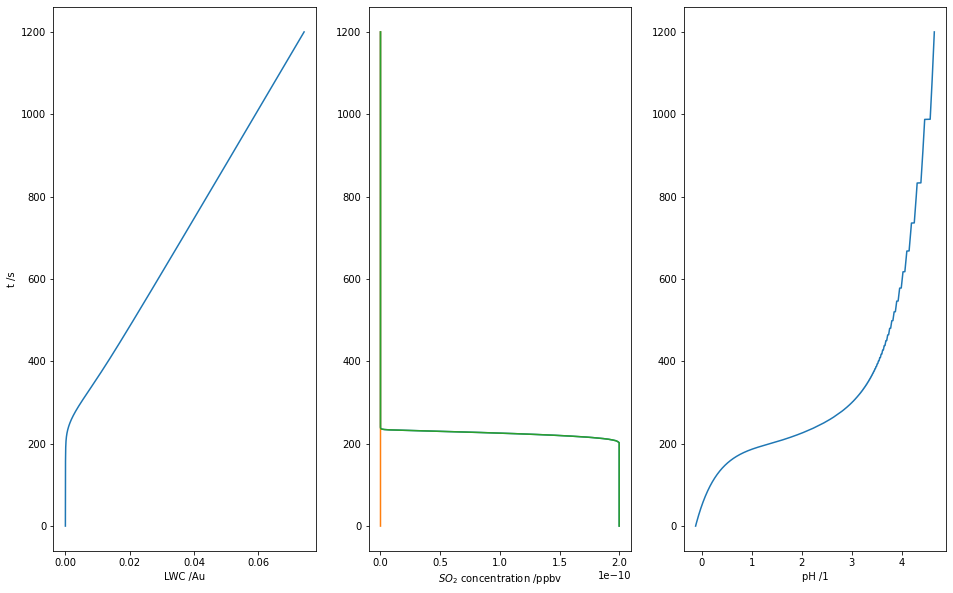

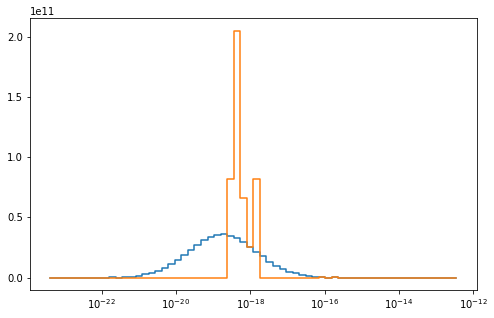

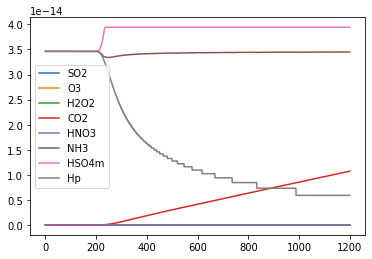

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plot1, plot2, plot3 = res

times, products = plot1

# Figure 1 reproduction plots

f, axs = plt.subplots(ncols=3)
f.set_size_inches(16, 10)
for ax, p, label in zip(axs, zip(*products), ["LWC /Au", "$SO_2$ concentration /ppbv", "pH /1"]):
    npp = np.array(p)
    ax.plot(npp, times)
    ax.set_xlabel(label)

axs[0].set_ylabel("t /s")
plt.show()

plt.gcf().set_size_inches(8, 5)

# Dry radius distribution

plt.step(fml.volume(setup.radius_bins_edges)[:-1], radii[0])
plt.step(fml.volume(setup.radius_bins_edges)[:-1], radii[-1])
plt.gca().set_xscale("log")
plt.show()

# Concentrations

for comp, lab in zip(np.array(plot3).T, COMPOUNDS.keys()):
    plt.plot(times, comp,label=lab)
plt.legend()
plt.show()